<a href="https://colab.research.google.com/github/bhagirathtallapragada/Secure-and-private-AI-CS8230/blob/main/lab3_defend_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/inspire-lab/SecurePrivateAI/blob/main/3_defend_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Defense with adversarial training

In this section we will use adversarial training to harden our CNN against adversarial examples. 

In adversarial training the dataset get "augmented" with adversarial examples that are correctly labeled. This way the network learns that such perturbations are possible and can adapt to them.

We will be using the IBM Adversarial Robustness Toolbox in this exercise. It offers a very easy-to-use implementation of adversarial training and a number of other defenses. 
https://github.com/IBM/adversarial-robustness-toolbox


We start out by importing most of the modules and functions we will need. 

In [ ]:
!pip install tensorflow-gpu==1.15.2 keras==2.2.3

     |████████████████████████████████| 312 kB 5.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires gast==0.4.0, but you have gast 0.2.2 which is incompatible.
tensorflow 2.6.0 requires keras~=2.6, but you have keras 2.2.3 which is incompatible.
tensorflow 2.6.0 requires tensorboard~=2.6, but you have tensorboard 1.15.0 which is incompatible.
tensorflow 2.6.0 requires tensorflow-estimator~=2.6, but you have tensorflow-estimator 1.15.1 which is incompatible.


In [ ]:
!pip install adversarial-robustness-toolbox==1.7.1

# DeprecationWarning: The module art.classifiers will be removed in ART 1.8.0 and replaced with art.estimators.classification

In [ ]:
# most of our imports
import warnings
import numpy as np
import os
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from art.classifiers import KerasClassifier


# helper code 
def extract_ones_and_zeroes( data, labels ):
    data_zeroes = data[ np.argwhere( labels == 0 ).reshape( -1 ) ][ :200 ]
    data_ones = data[ np.argwhere( labels == 1 ).reshape( -1 ) ][ :200 ]
    x = np.vstack( (data_zeroes, data_ones) )

    x = x / 255.
    print( x.shape )

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

def extract_two_classes( data, labels, classes=(0,1), no_instance=200 ):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

def convert_to_keras_image_format( x_train, x_test ):
    if keras.backend.image_data_format( ) == 'channels_first':
        x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
        x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    else:
        x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
        x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )

    return x_train, x_test


def mnist_cnn_model( x_train, y_train, x_test, y_test, epochs=2 ):
    # define the classifier
    clf = keras.Sequential( )
    clf.add( Conv2D( 32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[ 1: ] ) )
    clf.add( Conv2D( 64, (3, 3), activation='relu' ) )
    clf.add( MaxPooling2D( pool_size=(2, 2) ) )
    clf.add( Dropout( 0.25 ) )
    clf.add( Flatten( ) )
    clf.add( Dense( 128, activation='relu' ) )
    clf.add( Dropout( 0.5 ) )
    clf.add( Dense( y_train.shape[ 1 ], activation='softmax' ) )

    clf.compile( loss=keras.losses.categorical_crossentropy,
                 optimizer='adam',
                 metrics=[ 'accuracy' ] )

    clf.fit( x_train, y_train,
             epochs=epochs,
             verbose=1 )
    clf.summary( )
    score = clf.evaluate( x_test, y_test )
    print( 'Test loss:', score[ 0 ] )
    print( 'Test accuracy:', score[ 1 ] )

    return clf


def show_image( img ):
    plt.imshow( img.reshape( 28, 28 ), cmap="gray_r" )
    plt.axis( 'off' )
    plt.show( )

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The module art.classifiers will be removed in ART 1.8.0 and replaced with art.estimators.classification
  # Remove the CWD from sys.path while we load stuff.


We start out by loading the data, preparing it and training our CNN.

In [ ]:
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# extract ones and zeroes
x_train, y_train = extract_ones_and_zeroes( x_train, y_train )
x_test, y_test = extract_ones_and_zeroes( x_test, y_test )

# we need to bring the data in to a format that our cnn likes
y_train = keras.utils.to_categorical( y_train, 2 )
y_test = keras.utils.to_categorical( y_test, 2 )

# convert it to a format keras can work with
x_train, x_test = convert_to_keras_image_format(x_train, x_test)

# need to some setup so everything gets executed in the same tensorflow session
session = tf.Session( )
keras.backend.set_session( session )

# get and train our cnn
clf = mnist_cnn_model( x_train, y_train, x_test, y_test, epochs=5)


(400, 28, 28)
(400, 28, 28)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5




400/400 [==============================] - 2s 4ms/step - loss: 0.1800 - acc: 0.9025
Epoch 2/5
400/400 [==============================] - 1s 3ms/step - loss: 0.0402 - acc: 0.9900
Epoch 3/5
400/400 [==============================] - 1s 3ms/step - loss: 0.0317 - acc: 0.9925
Epoch 4/5
400/400 [==============================] - 1s 3ms/step - loss: 0.0168 - acc: 0.9950
Epoch 5/5
400/400 [==============================] - 1s 3ms/step - loss: 0.0121 - acc: 0.9975
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
________________________________________________________________

We want to know how robust our model is against an attack. To do this we are calculating the `empirical robustness`. This is equivalent to computing the minimal perturbation that the attacker must introduce for a    successful attack. We are following the approach of Moosavi-Dezfooli et al. 2016 (paper link: https://arxiv.org/abs/1511.04599), Eq.2.

The empirical robustness method supports two attacks at the moment.
The `Fast Gradient Sign Method` and `Hop Skip and Jump`.

You can use them by passing either `fgsm` or `hsj` as parameters.
The default attack parameters are the following:
```
    "fgsm", {"eps_step": 0.1, "eps_max": 1., "clip_min": 0., "clip_max": 1.},
    "hsj", {'max_iter': 50, 'max_eval': 10000, 'init_eval': 100, 'init_size': 100}
```

In [ ]:
from art.metrics import empirical_robustness

# wrap the model an calculate empirical robustness
wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the undefended model', 
      empirical_robustness( wrapper, x_test, 'fgsm'))

robustness of the undefended model 0.20006561977911033


Try different attack parameters and compare the results. 

Tip:

For `hsj` use only a few examples otherwise it will take forever.

In [ ]:
### your code goes here
x_small = x_test[ :10 ]
wrapper = KerasClassifier( model=clf, clip_values=(0., 1.) )
print( 'robustness of the undefended model', 
      empirical_robustness( wrapper, x_test, 'fgsm'))#, ("eps_step":0.1, "eps_max":1., "clip_min":0.,"clip_max":1.,)))

print( 'robustness of the undefended model ', empirical_robustness( wrapper, x_test, 'fgsm', {"eps_step": 0.5, "eps_max":1., "clip_min":0.,"clip_max":1.,}))

print( 'robustness of the undefended model under hsj', empirical_robustness( wrapper, x_test, 'hsj', {"max_iter": 50, "max_eval":10000, "init_eval":100,"init_size":100}))

robustness of the undefended model 0.2000828873577624
robustness of the undefended model  0.0


HopSkipJump:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/usr/local/lib/python3.7/dist-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Container


KeyboardInterrupt: ignored

Let's create an adversarial example and see how it looks.
We want to know how to the model performs on adversarial examples. Let's create adversarial examples out of the training set and see how the model does with it.

Below you can the keyword arguments for the attack

```
norm=np.inf, eps=.3, eps_step=0.1, targeted=False, num_random_init=0, batch_size=1, minimal=False
        """
        :param norm: The norm of the adversarial perturbation. Possible values: np.inf, 1 or 2.
        :param eps: Attack step size (input variation)
        :param eps_step: Step size of input variation for minimal perturbation computation
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False)
        :param num_random_init: Number of random initialisations within the epsilon ball. For random_init=0 starting at
            the original input.
        :param batch_size: Size of the batch on which adversarial samples are generated.
        :param minimal: Indicates if computing the minimal perturbation (True). If True, also define `eps_step` for
                        the step size and eps for the maximum perturbation.
   
```

class prediction for the adversarial sample: [[1.0000000e+00 3.0835608e-08]]


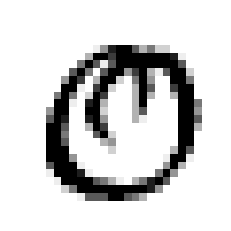

accuracy on adversarial examples:
400/400 [==============================] - 0s 806us/step
0.495


In [ ]:
# create an adversarial example with fgsm and plot it
from art.attacks.evasion import FastGradientMethod
fgsm = FastGradientMethod( wrapper, eps=0.4 )
x_adv = fgsm.generate(x_test[128].reshape((1,28,28,1) ))
print( 'class prediction for the adversarial sample:',
       clf.predict( x_adv.reshape((1,28,28,1) ) ) )
show_image( x_adv )

# create adversarial examples for the all of the set

x_test_adv = fgsm.generate( x_test )
print( 'accuracy on adversarial examples:' )
print( wrapper._model.evaluate( x_test_adv, y_test )[ 1 ] )


## Adversarial Training

Let's create a new untrained model with the same architecture that we have been using so far. 

We will train the model using adversarial training framework. The idea is very simple:

1.   Train the model for 1 epoch
2.   Create adversarial examples using FGSM 
3.   Enhance training data by mixing it with the adversarial examples. (Only mix in the adversarial examples created in this iteration)
4.   Goto 1

We will be using the FGSM attack from `art` this time.




In [ ]:
# create a new untrained model and wrap it
new_model = mnist_cnn_model( x_train, y_train, x_test, y_test, epochs=0 )
defended_model = KerasClassifier(clip_values=(0,1), model=new_model )
# define the attack we are using
fgsm = FastGradientMethod( defended_model, eps=.4 )

# parameters
epochs = 5 # number of iterations that we will perform training for
ratio = .5  # ratio of the test set that will get turned into adversarial examples
            # each iteration


# some helpers
idx = np.arange( x_train.shape[ 0 ], dtype=np.int )

# create varialbes to hold the training data.
# for now it is just the normal training data. we'll mix in the 
# adversarial examples in later
x_train_enhanced = x_train
y_train_enhanced = y_train


for i in range( epochs ):
  # train model for one epoch
  defended_model.fit(x_train_enhanced, y_train_enhanced, nb_epochs=1)
  # shuffle   
  np.random.shuffle(idx)

  # pick the subset of the train data to turn into adversarial examples
  x_train_ = x_train[idx[int(idx.shape[0] * ratio) :]]
  y_train_ = y_train[idx[int(idx.shape[0] * ratio) :]]
  
  # create adversarial examples
  #fgsm = FastGradientMethod( new_model, eps=0.4 )
  x_adv = fgsm.generate(x_train_)

  # add the adversarial examples to the training data
  # xtrain_enhanced.append(x_adv)
  x_train_enhanced= np.vstack((x_train, x_adv))
  y_train_enhanced= np.vstack((y_train, y_train_ ))

  # break

# training is done. let's evaluate the performance on the test set
# and adversarial examples
acc = defended_model._model.evaluate( x_test, y_test )[ 1 ]
print( 'acc on the test data: ', acc )

# and now on adversarial examples
x_test_adv = fgsm.generate( x_test )
acc =  defended_model._model.evaluate( x_test_adv, y_test )
print( 'accuracy on adversarial examples: ', acc )


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

To use the adversarial training that comes with `art`, we need to pass our wrapped model to an `AdversarialTrainer` instance. The `AdversarialTrainer` also needs an instance of the attack that will be used to create the adversarial examples.

https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/trainer.html#art.defences.trainer.AdversarialTrainer

https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/adversarial_training_cifar10.py

In [ ]:
from art.defences.trainer import AdversarialTrainer

# get a new untrained model and warp it
new_model = mnist_cnn_model( x_train, y_train, x_test, y_test, epochs=0 )
defended_model = KerasClassifier(clip_values=(0,1), model=new_model )
# define the attack we are using
fgsm = FastGradientMethod( defended_model, eps=0.4 )

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

Create the `AdversarialTrainer` instance. 
Train the model and evaluate it on the test data.

In [ ]:
# define the adversarial trainer and train the new network
adversarial_trainer = AdversarialTrainer( defended_model, fgsm )
adversarial_trainer.fit( x_train, y_train, batch_size=100, nb_epochs=5 )

# evaluate how good our model is
defended_model._model.evaluate( x_test,y_test )

# and now on adversarial examples
x_test_adv = fgsm.generate( x_test )
acc = defended_model._model.evaluate( x_test_adv, y_test )
print( 'loss and accuracy on adversarial examples: ', acc )


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

400/400 [==============================] - 0s 880us/step
loss and accuracy on adversarial examples:  [0.42128058671951296, 0.9275]


Calculate the `empirical robustness` for our now hopefully more robust model.

robustness of the defended model 0.18015748299951628
class prediction for the adversarial sample: [[0.99866843 0.00133155]]


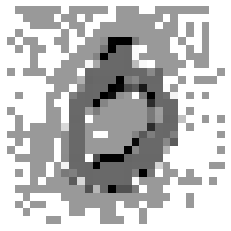

In [ ]:
# calculate the empiracal robustness
print( 'robustness of the defended model', 
      empirical_robustness( defended_model, x_test[0:], 'fgsm', {}) )

x_adv = fgsm.generate(x_test[0].reshape((1,28,28,1) ))
print( 'class prediction for the adversarial sample:',
       clf.predict( x_adv.reshape((1,28,28,1) ) ) 
     )
plt.imshow( x_adv.reshape( 28, 28 ), cmap="gray_r" )
plt.axis( 'off' )
plt.show( )

# Defensive Distillation

The idea behind defensive distillation is to transfer robustness from one network to another. To do this we are training two networks. The first network, which we will call `one` is trained normally. We want to transfer some of *experience* to our second network, called `two`. Both `one` and `two` have the same architecture. The way we achieve is this is by training `two` with the outputs of `one`. An important change is that we are using a so called *temperature* `T` parameter in the softmax function.
The process is as follows:


1.   Train `one` at temperature `T`
2.   Create new labels for the training data using `one`
3.   Train `two` at temperature `T` using the new labels


Hints:


*   `tf.math.exp`
*   `keras.backend.in_train_phase`
*   kullback leibler divergence

Loss: $H(\sigma (z^T/ρ), \sigma (z^S/ρ))$ , T: teacher, S: student, H: Entropy Loss

Fig: ![kd](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11263-021-01453-z/MediaObjects/11263_2021_1453_Fig4_HTML.png)

Ref:

* https://arxiv.org/pdf/1503.02531.pdf



In [ ]:
import tensorflow as tf
# softmax with temperature
T = 10
def softmax_with_temp( x ):
  return keras.backend.in_train_phase (
      # your code here
      #??? # using temperature,
      tf.math.exp(x/T) / tf.reduce_sum(x/T, axis=1, keep_dims=True),
      # tf.nn.softmax(x/T),
      tf.nn.softmax( x )
  )
  

# define the classifier one
one = keras.Sequential( )
one.add( Conv2D( 32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[ 1: ] ) )
one.add( Flatten( ) )
one.add( Dense( 128, activation='relu' ) )
one.add( Dense( y_train.shape[ 1 ], activation=softmax_with_temp ) )

# train the classifier one and evaluate on clean test data.
one.compile( loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=[ 'accuracy' ] )

one.fit( x_train, y_train, epochs=epochs, verbose=1 )

one.summary( )

score = one.evaluate( x_test, y_test )
print( 'Test loss:', score[ 0 ] )
print( 'Test accuracy:', score[ 1 ] )


# test the FGSM attack
one_wrapped = KerasClassifier(clip_values=(0,1), model=one )
fgsm = FastGradientMethod( one_wrapped, eps=0.4 )
x_test_adv = fgsm.generate( x_test )
acc =  one.evaluate( x_test_adv, y_test )
print( 'accuracy on adversarial examples: ', acc )

# create new labels
y_train_new = one.predict( x_train )


# define the classifier two
two = keras.Sequential( )
two.add( Conv2D( 32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[ 1: ] ) )
two.add( Flatten( ) )
two.add( Dense( 128, activation='relu' ) )
two.add( Dense( y_train.shape[ 1 ], activation=softmax_with_temp ) )

# train the classifier two and evaluate on clean test data using compile and fit as above
# your code here
#???
two.compile( loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=[ 'accuracy' ] )

two.summary( )
score = two.evaluate( x_test, y_test )
print( 'Test loss:', score[ 0 ] )
print( 'Test accuracy:', score[ 1 ] )


# test the FGSM attack

print( 'accuracy on adversarial examples: ', acc )


Instructions for updating:
keep_dims is deprecated, use keepdims instead


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Epoch 1/5
400/400 [==============================] - 2s 5ms/step - loss: 0.3180 - acc: 0.9425
Epoch 2/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0299 - acc: 0.9950
Epoch 3/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0193 - acc: 0.9975
Epoch 4/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0121 - acc: 0.9975
Epoch 5/5
400/400 [==============================] - 1s 2ms/step - loss: 0.0072 - acc: 0.9975
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_9 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               2769024   
_________________________________________________________________
de

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_10 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               2769024   
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 258       
Total params: 2,769,602
Trainable params: 2,769,602
Non-trainable params: 0
_________________________________________________________________
400/400 [==============================] - 1s 3ms/step
Test loss: 0.7151124429702759
Test accuracy: 0.2175
accuracy on adversarial examples:  [1.1920928955078125e-07, 1.0]


# Black box attacks

Assume we do not have access to the internal workings of our target model. This means we can not easily calculate gradients.
Fortunately or unfortunate depending on how you are looking at it adversarial examples created on one model can be also used against a different model. Given their learned decision boundary is similar enough.

We do not know what the target model looks like but in most cases we know the domain that it works in, MNIST in our case, so we can make an educated guess. We then train our model with the architecture that we guessed and create adversarial examples using this model. If our model and the target model are similar enough the adversarial examples can be transfered.


In the code below we will be training two different models and see if the adversarial examples transfer from one to the other.

Fig: ![bba](https://miro.medium.com/max/1400/1*6FUwsVaUsrtzmKUO_YP-8A.png)

Ref: https://arxiv.org/abs/1602.02697

In [ ]:
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Reshape
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# extract ones and zeroes
x_train, y_train = extract_ones_and_zeroes( x_train, y_train )
x_test, y_test = extract_ones_and_zeroes( x_test, y_test )

# we need to bring the data in to a format that our cnn likes
y_train = keras.utils.to_categorical( y_train, 2 )
y_test = keras.utils.to_categorical( y_test, 2 )

# convert it to a format keras can work with
x_train, x_test = convert_to_keras_image_format(x_train, x_test)

# Create simple CNN
model_0 = mnist_cnn_model( x_train, y_train, x_test, y_test, epochs=5 )
print( model_0.evaluate( x_test, y_test )[ 1 ] )


# create a simple DNN
model_1 = Sequential()
model_1.add( Reshape(  [28 * 28 ], input_shape=x_train.shape[ 1: ] ) )# flatten the data
model_1.add( Dense( 512, activation='relu' ) ) 
model_1.add( Dense( 128, activation='relu' ) ) 
model_1.add( Dense( 2, activation='softmax' ) ) 

# train model_1
model_1.compile( loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=[ 'accuracy' ] )
model_1.fit( x_train, y_train, epochs=5 )

# compare how the models do on the test set
acc_0 = model_0.evaluate( x_test, y_test )[ 1 ]
acc_1 = model_1.evaluate( x_test, y_test )[ 1 ]

print( 'acc model 0: ', acc_0 )
print( 'acc model 1: ', acc_1 )


# compare how the models perform on adversarial examples
# use KerasClassifier and FastGradientMethod
# your code here
# fgsm_0 = ???
# adv_0 = fgsm_0.???
wrapper_1= keras.classifier()

fgsm_1 = ???
adv_1 = fgsm_1.???

print( 'acc model 0 on adverserial examples: ', model_0.evaluate( adv_0, y_test, verbose=0 )[ 1 ] )
print( 'acc model 1 on adverserial examples: ', model_1.evaluate( adv_1, y_test, verbose=0 )[ 1 ] )


# let's see how the models do when we give them the adversarial examples 
# created against the other model
print( 'acc model 0 on adversarial examples from model 1: ', ??? )
print( 'acc model 1 on adversarial examples from model 0: ', ??? )
